In [1]:
pip install --upgrade scikit-learn







Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install squarify



Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install numpy==1.23.0



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 23.4 MB/s eta 0:00:0000:0100:01


  Attempting uninstall: numpy

    Found existing installation: numpy 1.23.5

    Uninstalling numpy-1.23.5:

      Successfully uninstalled numpy-1.23.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.

momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.

pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.0 which is incompatible.

pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.

ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.





In [55]:

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, auc,average_precision_score,ConfusionMatrixDisplay,
    roc_curve, recall_score, classification_report, f1_score,
    precision_recall_fscore_support, accuracy_score, roc_auc_score, precision_score,
    brier_score_loss
)
import os
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.metrics import brier_score_loss, precision_score
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import (
    StratifiedKFold, KFold, RepeatedKFold, GroupKFold,
    GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold, cross_val_score
)
from sklearn import preprocessing, metrics
import gc
import warnings
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
from sklearn.feature_selection import f_classif, SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('fivethirtyeight')

# Printing Kaggle input file paths
print("Kaggle input file paths:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




Kaggle input file paths:

/kaggle/input/widsdatathon2020/unlabeled.csv

/kaggle/input/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv

/kaggle/input/widsdatathon2020/samplesubmission.csv

/kaggle/input/widsdatathon2020/solution_template.csv

/kaggle/input/widsdatathon2020/training_v2.csv


# Load training/test data

In [5]:
data = pd.read_csv("/kaggle/input/widsdatathon2020/training_v2.csv")
#test = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")
dictionary = pd.read_csv("/kaggle/input/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv")

------------------

# 1. Split the data file from job 1 into train and test. When the train file contains 80% of the records

In [6]:
X = data.drop(["hospital_death"],axis=1, inplace = False)
y = data["hospital_death"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Choose the best model you trained at work-

# **Pre-Process**

## simple preprocess
Handle Unneccesry Data-

a. Drop columns with a single unique value

b. Drop columns with more them 80% missing values

c. Define All Categorial Columns

In [8]:
# a. Check for columns with unique values in 'train' dataframe
cols_to_drop = []
for column in X_train.columns:
    if X_train[column].nunique() == 1 or X_train[column].nunique() == X_train.shape[0]:
        cols_to_drop.append(column)

# Dropping columns with unique values
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
print(cols_to_drop)


['encounter_id', 'patient_id', 'readmission_status']


In [9]:
# b. create the dict-cols_to_drop with all the coulmns that have more then 80% missing values
missing_threshold = 80
missing_percent = (X_train.isnull().sum() / len(X_train)) * 100
cols_with_missing_data_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()

In [10]:
# c. Define of categorical variables
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features  = X_train.columns.difference(categorical_features).tolist()

In [11]:
# update the numric and categories list to be without the cols to drop, and then drop the cols from tain and test 
updated_numeric_features = [col for col in numeric_features if col not in cols_with_missing_data_to_drop]
updated_categorical_features = [col for col in categorical_features if col not in cols_with_missing_data_to_drop]
X_train = X_train.drop(cols_with_missing_data_to_drop, axis=1)
X_test = X_test.drop(cols_with_missing_data_to_drop, axis=1)

print("Total features dropped:", len(cols_with_missing_data_to_drop))
print("Train Shape after dropping:", X_train.shape)
print("Test Shape after dropping:", X_test.shape)

Total features dropped: 34

Train Shape after dropping: (73370, 148)

Test Shape after dropping: (18343, 148)


In [12]:
num_cols_norm = []
num_cols_non_norm = []

for feature in updated_numeric_features:
    if '_min' in feature or '_max' in feature or 'apache' in feature:
        num_cols_norm.append(feature)
    else:
        num_cols_non_norm.append(feature)

In [13]:
#Replace all missing data in the normally distributed coulmns with the meadian
for col in num_cols_norm:
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_test[col].fillna(X_test[col].median(), inplace=True)


In [14]:
#Replace all missing data in the non-normally distributed coulmns with the average
for col in num_cols_non_norm:
    X_train[col].fillna(X_train[col].mean(), inplace=True)
    X_test[col].fillna(X_test[col].mean(), inplace=True)


In [15]:
# Replace categorial feature with the most common
for col in updated_categorical_features:
    X_train[col].fillna( X_train[col].mode()[0], inplace = True)
    X_test[col].fillna( X_test[col].mode()[0], inplace = True)

**Categorical Encoding**

In [16]:
lencoders = {}
for col in updated_categorical_features:
    lencoders[col] = LabelEncoder()
    X_train[col] = lencoders[col].fit_transform(X_train[col])
    X_test[col] = lencoders[col].transform(X_test[col])

**Discretisation**

In [17]:
#Create bins for BMI variable
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = [0, 1, 2, 3]
X_train['bmi_category'] = pd.cut(X_train['bmi'], bins=bmi_bins, labels=bmi_labels)
X_test['bmi_category'] = pd.cut(X_test['bmi'], bins=bmi_bins, labels=bmi_labels)
updated_categorical_features = updated_categorical_features
X_train.drop(['bmi_category'], axis=1)
X_test.drop(['bmi_category'], axis=1)

,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
54965,194,59.00000,20.571429,0,0,1,175.0,3,0,594,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,10,7
78059,18,62.46309,23.119157,0,0,1,190.5,3,4,804,...,0.00066,0.015837,0.22744,0.013253,0.024031,0.007259,0.003959,0.020016,0,0
70670,13,48.00000,37.487687,0,2,1,175.3,3,1,708,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
73829,92,58.00000,32.289347,0,5,1,167.6,3,0,707,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
41278,20,62.46309,26.280500,0,2,1,177.5,3,0,483,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27373,147,79.00000,25.951557,0,2,0,170.0,3,0,394,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
41587,100,55.00000,65.773578,0,2,1,193.0,3,0,487,...,0.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
27646,161,73.00000,23.885384,0,2,1,175.3,3,0,324,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,10,7
72563,185,76.00000,31.344507,0,2,0,152.4,3,0,687,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,7,4


**Normaliztion**


In [18]:
#normalizing the age and height
scaler = MinMaxScaler()
X_train['age_normalized'] = scaler.fit_transform(X_train[['age']])
X_train['height_normalized'] = scaler.fit_transform(X_train[['height']])
X_test['age_normalized'] = scaler.fit_transform(X_test[['age']])
X_test['height_normalized'] = scaler.fit_transform(X_test[['height']])

In [19]:
#update the updated_numeric_features list with the categorical features after enccoding them
updated_numeric_features = updated_numeric_features+ updated_categorical_features

**Random Forest 100 trees**

In [20]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=20)
random_forest.fit(X_train, y_train)
prediction_y_train = random_forest.predict(X_train)
prediction_y = random_forest.predict(X_test)

# 3. Train a baseline model for comparison

**3.1 Pre-Processing**

In [21]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# a. Check for columns with unique values in 'train' dataframe
cols_to_drop = []
for column in X_train_base.columns:
    if X_train_base[column].nunique() == 1 or X_train_base[column].nunique() == X_train_base.shape[0]:
        cols_to_drop.append(column)

# Dropping columns with unique values
X_train_base = X_train_base.drop(cols_to_drop, axis=1)
X_test_base = X_test_base.drop(cols_to_drop, axis=1)
print(cols_to_drop)


['encounter_id', 'patient_id', 'readmission_status']


In [23]:
# b. create the dict-cols_to_drop with all the coulmns that have more then 80% missing values
missing_threshold = 80
missing_percent = (X_train_base.isnull().sum() / len(X_train_base)) * 100
cols_with_missing_data_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()

In [24]:
# c. Define of categorical variables
categorical_features = X_train_base.select_dtypes(include=['object']).columns.tolist()
numeric_features  = X_train_base.columns.difference(categorical_features).tolist()

In [25]:
# update the numric and categories list to be without the cols to drop, and then drop the cols from tain and test 
updated_numeric_features = [col for col in numeric_features if col not in cols_with_missing_data_to_drop]
updated_categorical_features = [col for col in categorical_features if col not in cols_with_missing_data_to_drop]
X_train_base = X_train_base.drop(cols_with_missing_data_to_drop, axis=1)
X_test_base = X_test_base.drop(cols_with_missing_data_to_drop, axis=1)

print("Total features dropped:", len(cols_with_missing_data_to_drop))
print("Train Shape after dropping:", X_train_base.shape)
print("Test Shape after dropping:", X_test_base.shape)

Total features dropped: 34

Train Shape after dropping: (73370, 148)

Test Shape after dropping: (18343, 148)


In [26]:
num_cols_norm = []
num_cols_non_norm = []

for feature in updated_numeric_features:
    if '_min' in feature or '_max' in feature or 'apache' in feature:
        num_cols_norm.append(feature)
    else:
        num_cols_non_norm.append(feature)

In [27]:
#Replace all missing data in the normally distributed coulmns with the meadian
for col in num_cols_norm:
    X_train_base[col].fillna(X_train_base[col].median(), inplace=True)
    X_test_base[col].fillna(X_test_base[col].median(), inplace=True)


In [28]:
#Replace all missing data in the non-normally distributed coulmns with the average
for col in num_cols_non_norm:
    X_train_base[col].fillna(X_train_base[col].mean(), inplace=True)
    X_test_base[col].fillna(X_test_base[col].mean(), inplace=True)


In [29]:
# Replace categorial feature with the most common
for col in updated_categorical_features:
    X_train_base[col].fillna( X_train_base[col].mode()[0], inplace = True)
    X_test_base[col].fillna( X_test_base[col].mode()[0], inplace = True)

In [30]:
lencoders = {}
for col in updated_categorical_features:
    lencoders[col] = LabelEncoder()
    X_train_base[col] = lencoders[col].fit_transform(X_train_base[col])
    X_test_base[col] = lencoders[col].transform(X_test_base[col])

In [31]:
random_forest_base = RandomForestClassifier()
random_forest_base.fit(X_train_base, y_train_base)
prediction_y_train_base = random_forest_base.predict(X_train_base)
prediction_y_base = random_forest_base.predict(X_test_base)

# 4. Present in an orderly manner the accuracy performance of the two models on the train and test files.

Model: train_model, f1_macro: 0.9209128385067662, roc_auc: 0.8723925410872313, average_precision: 0.7667968035864839


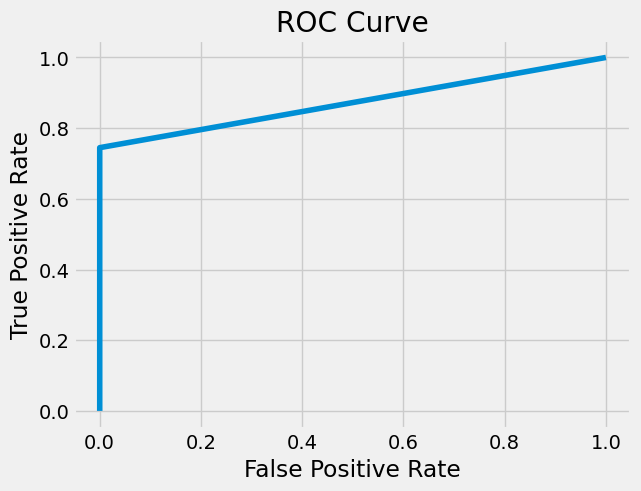

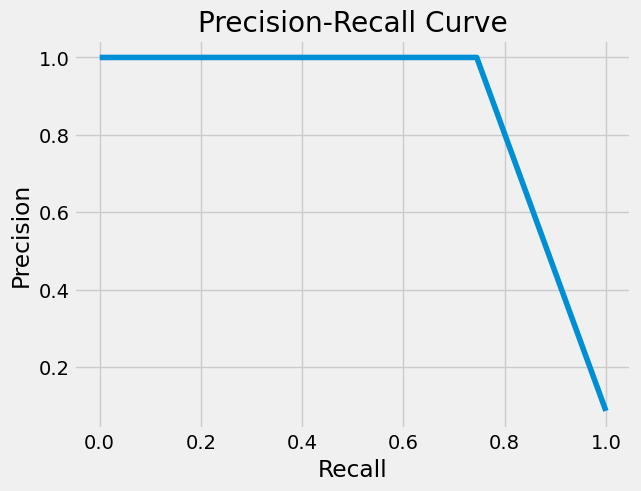

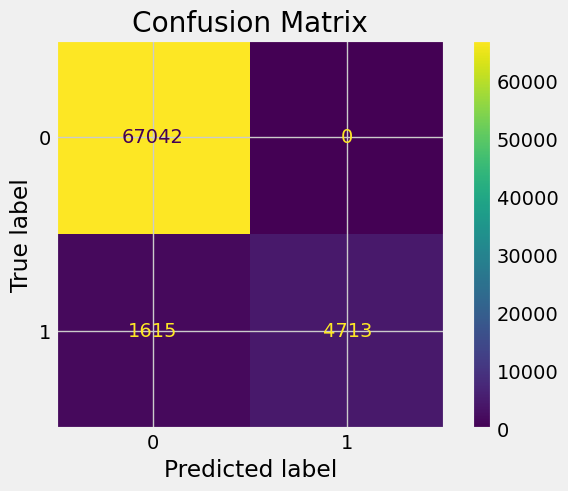

Model: test_model, f1_macro: 0.6907708146589879, roc_auc: 0.6410684665918465, average_precision: 0.2777481512783836


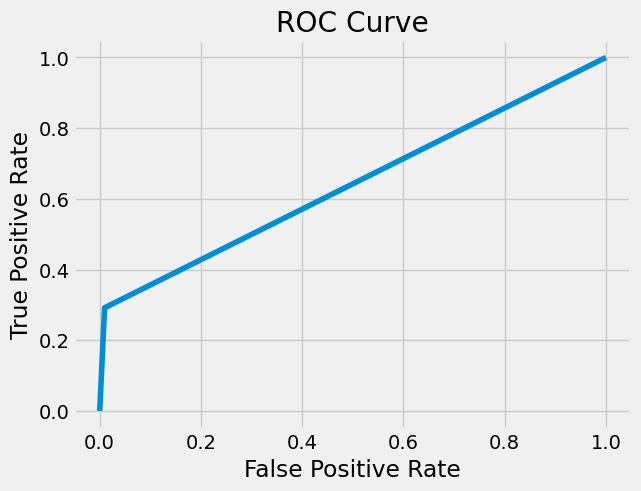

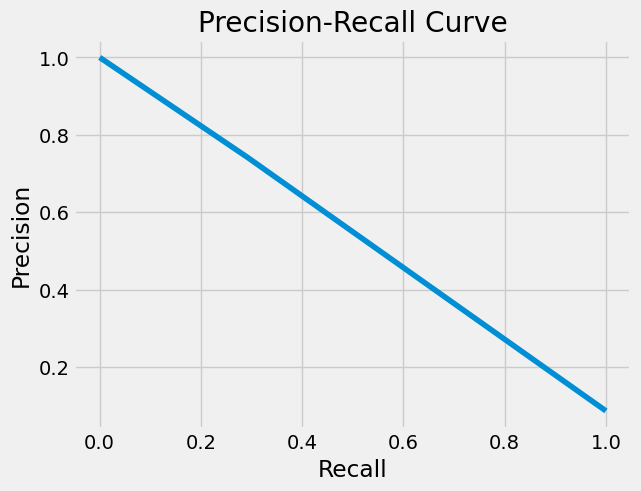

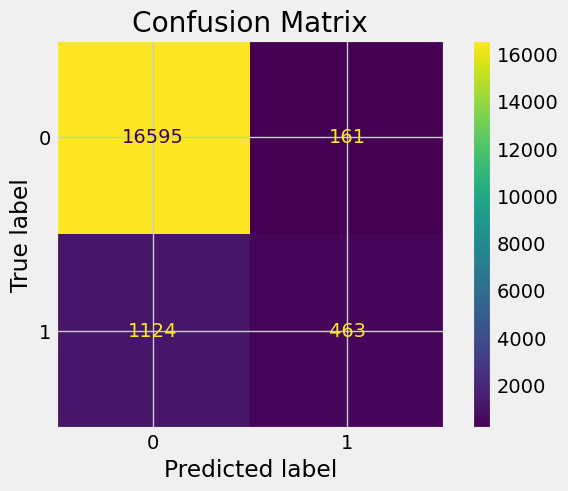

Model: train_baseline_model, f1_macro: 0.9998702642724786, roc_auc: 0.9997629582806574, average_precision: 0.9995668052079006


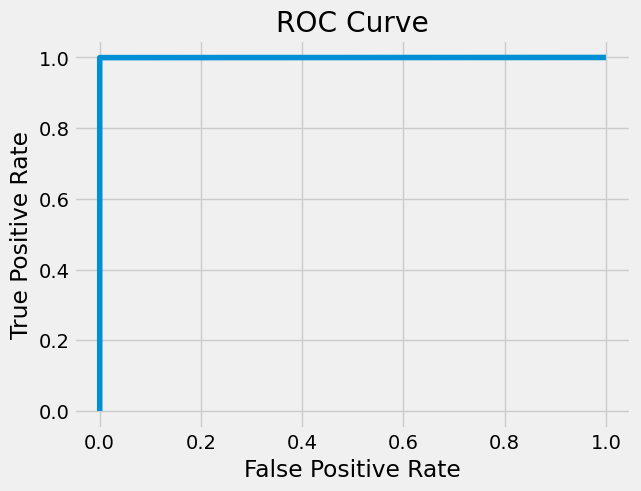

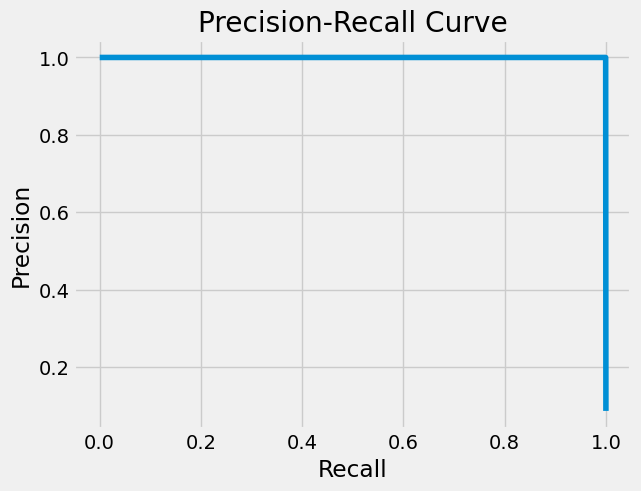

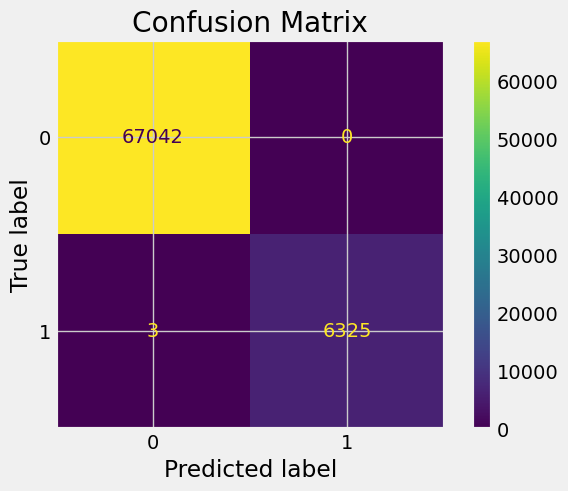

Model: test_baseline_model, f1_macro: 0.6924039422145898, roc_auc: 0.642584085784129, average_precision: 0.2797226481115177


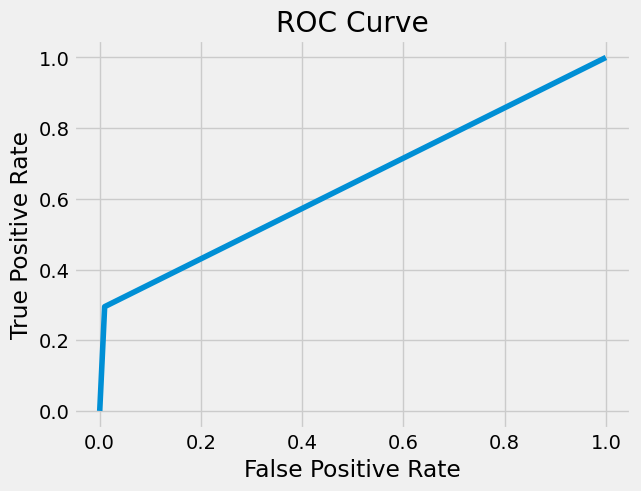

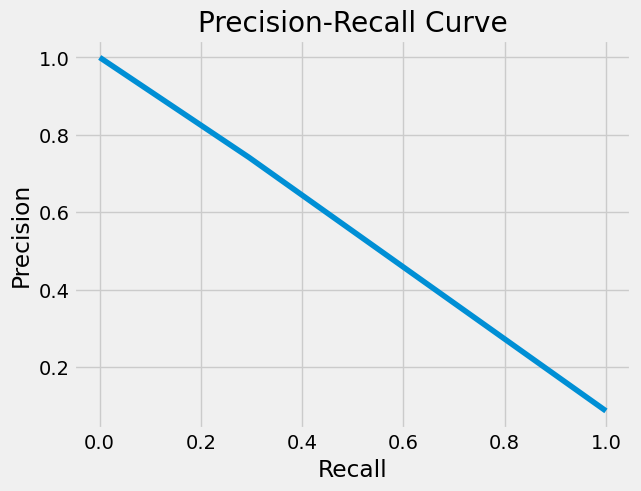

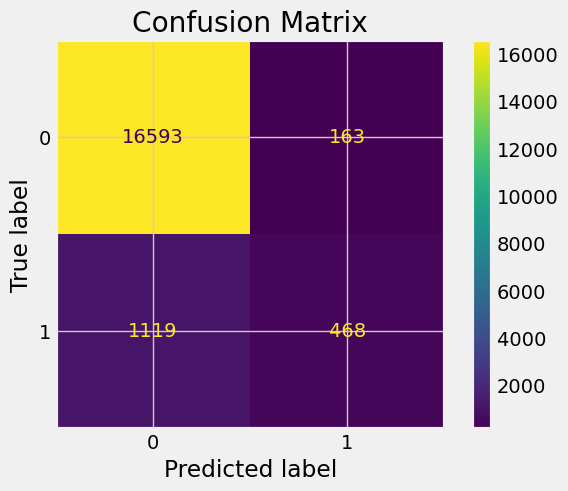

In [58]:

# Define scoring function
def calculate_scores(y_true, y_pred, name):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    print(f"Model: {name}, f1_macro: {f1_macro}, roc_auc: {roc_auc}, average_precision: {average_precision}")
    return f1_macro, roc_auc, average_precision

# Define plotting function
def plot_evaluation(y_true, y_pred):
    # Create ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred) 
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    # Create precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')

    plt.show()

# Train model
best_model_train_scores = calculate_scores(y_train, prediction_y_train, 'train_model')
plot_evaluation(y_train, prediction_y_train)

# Test model
best_model_test_scores = calculate_scores(y_test, prediction_y, 'test_model')
plot_evaluation(y_test, prediction_y)

# Train baseline model
baseline_model_train_scores = calculate_scores(y_train, prediction_y_train_base, 'train_baseline_model')
plot_evaluation(y_train, prediction_y_train_base)

# Test baseline model
baseline_model_test_scores = calculate_scores(y_test, prediction_y_base, 'test_baseline_model')
plot_evaluation(y_test, prediction_y_base)





# 5. Activate the SAHP method to provide explanations about the model from section 2- (TreeShap)

In [33]:
shap.initjs()

# 6. Apply the SAHP method to the baseline model from section 3.

In [34]:
# Tree SHAP train
X_train_sahp = X_train.sample(n=200, random_state=42)
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train_sahp)

In [ ]:
# Tree SHAP  baseline
X_train_baseline_sample = X_train_base.sample(n=500, random_state=42)
explainer_tree = shap.TreeExplainer(random_forest_base)
shap_values_tree = explainer_tree.shap_values(X_train_baseline_sample)

# Kernel SHAP baseline
X_summary = shap.kmeans(X_train_base, 10)
explainer_kernel = shap.KernelExplainer(random_forest_base.predict, X_summary)
shap_values_kernel = explainer_kernel.shap_values(X_train_baseline_sample)

# 7. Present the results of the explanations you created - for each of the three sessions of SHAP (once for the model from section 2, and twice for the model from section 3).

summary_plot

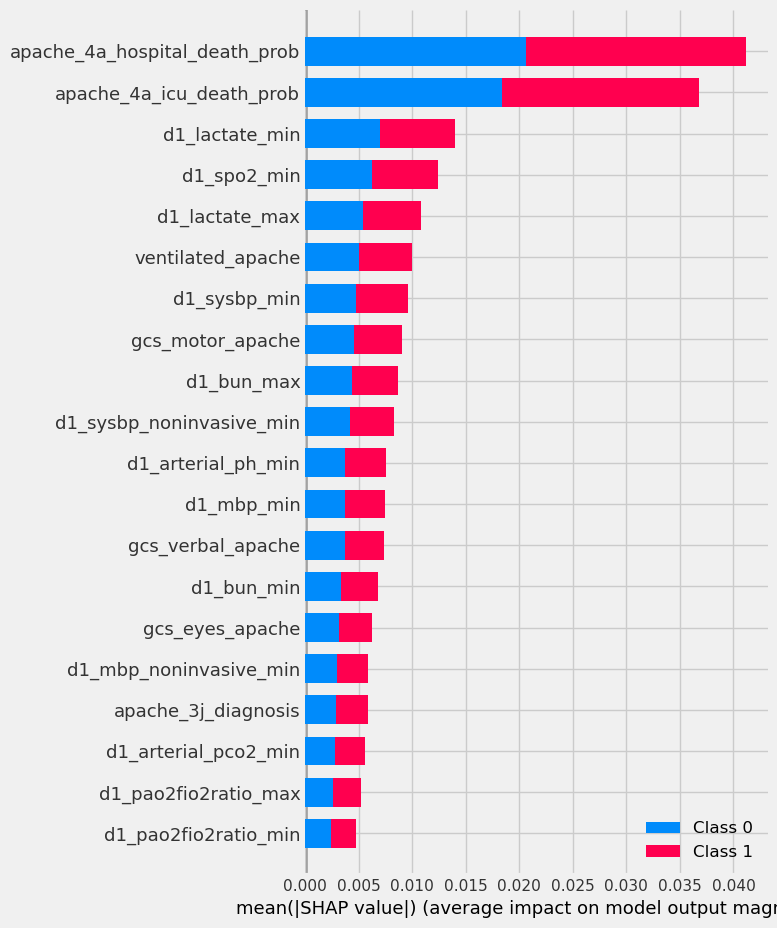

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


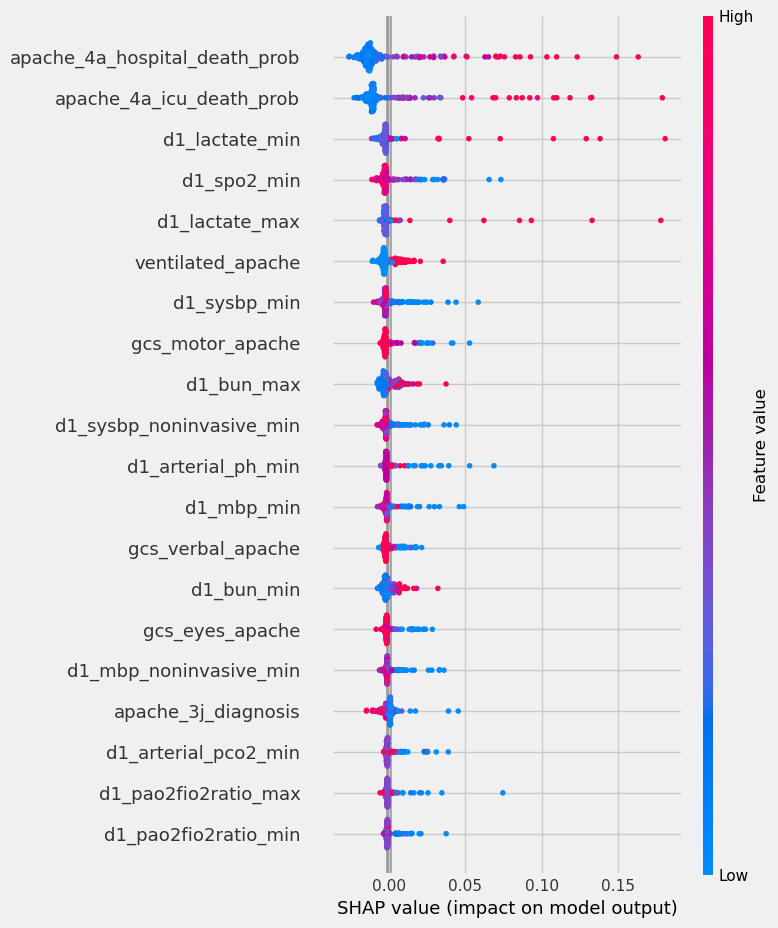

In [36]:
shap.summary_plot(shap_values, X_train_sahp , plot_type='bar')
shap.summary_plot(shap_values[1], X_train_sahp)


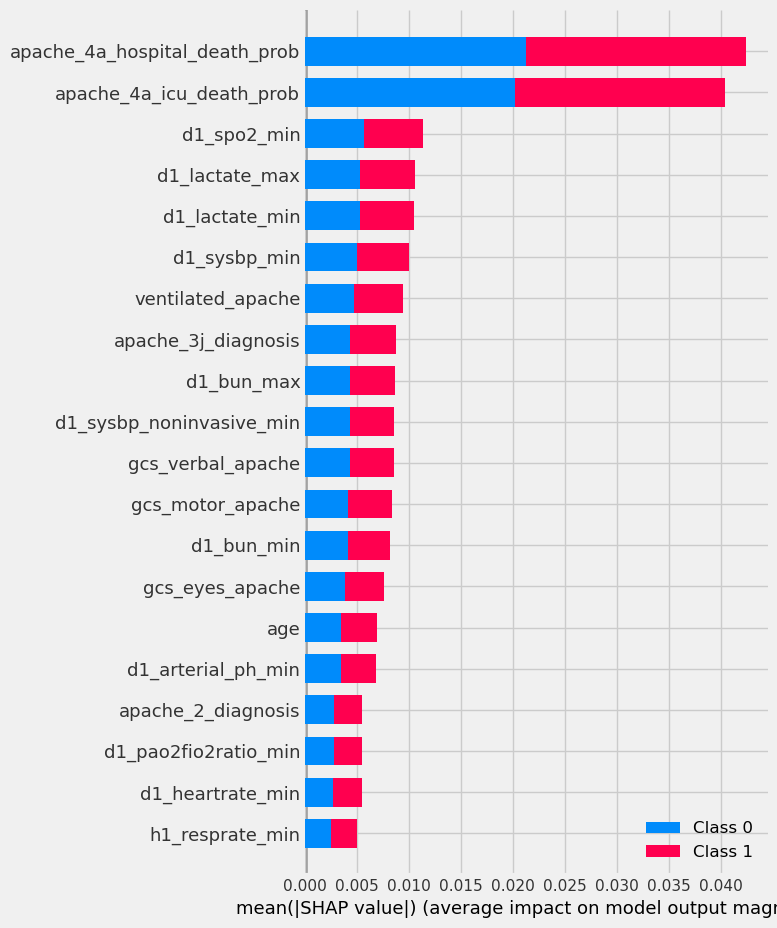

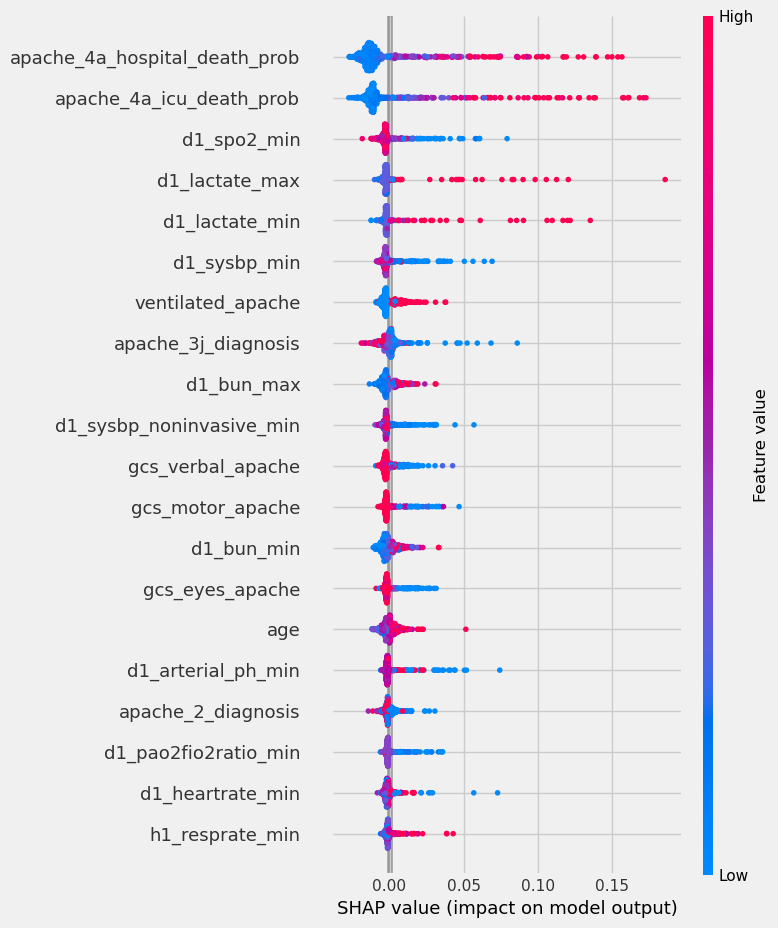

In [37]:
shap.summary_plot(shap_values_tree, X_train_baseline_sample, plot_type='bar')
shap.summary_plot(shap_values_tree[1], X_train_baseline_sample)


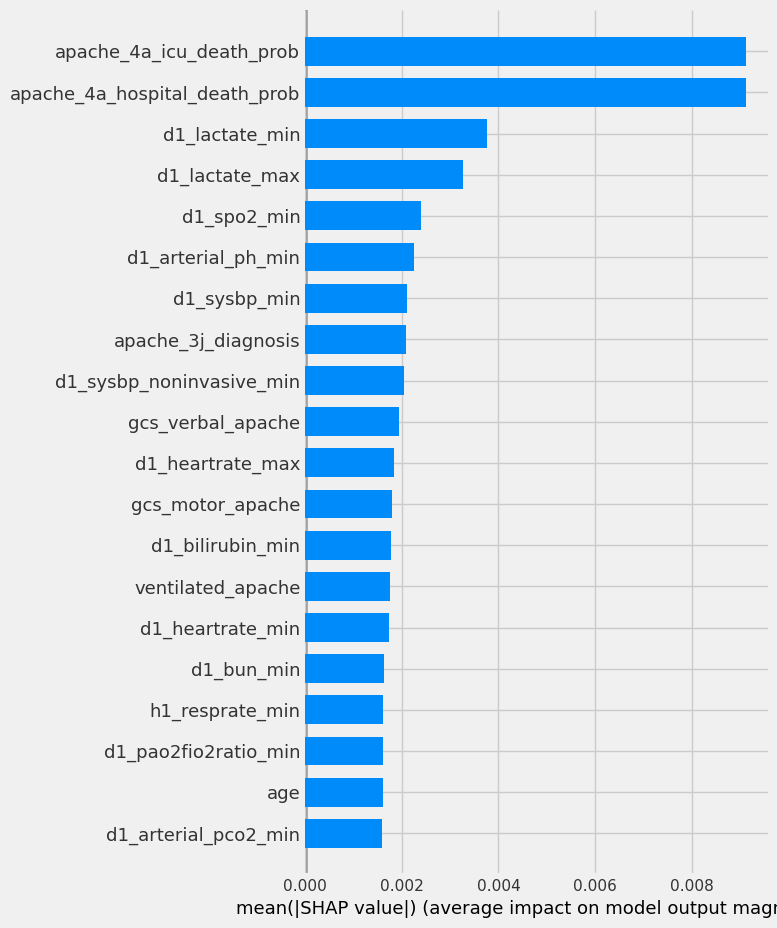

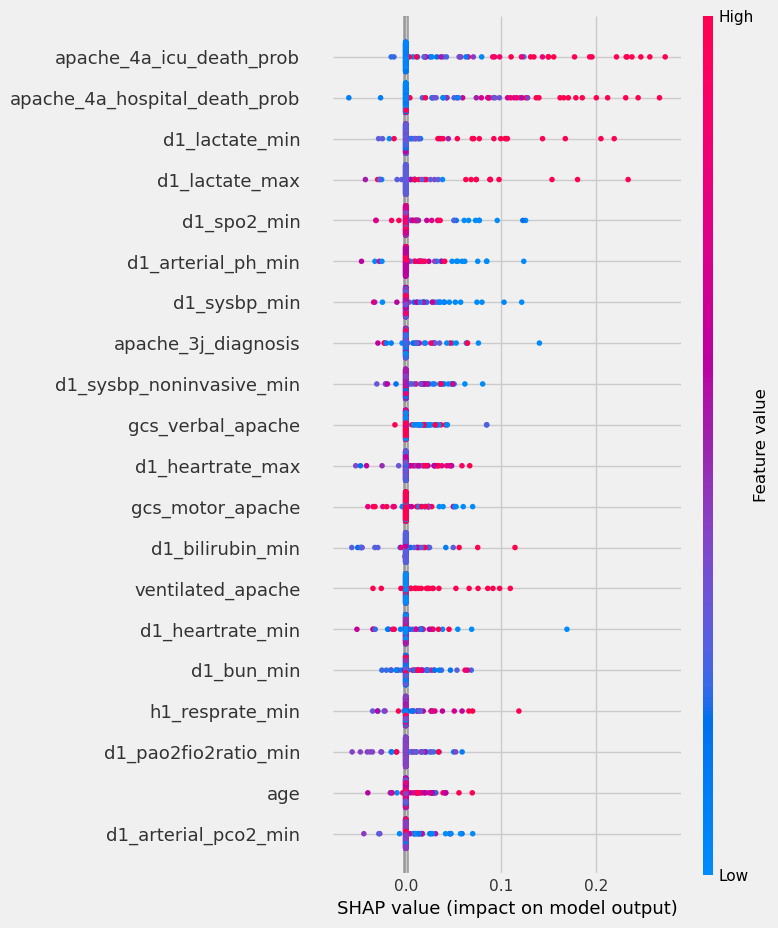

In [38]:
shap.summary_plot(shap_values_kernel, X_train_baseline_sample, plot_type='bar')
shap.summary_plot(shap_values_kernel, X_train_baseline_sample)

-------------------------------

# 8. Run the SHAP method on the model from section 2, but this time on the test file. Display the Global Feature Importance, and Summary Plot charts.

In [39]:
X_test = X_test.sample(n=200, random_state=42)
explainer_test = shap.TreeExplainer(random_forest)
shap_values_test = explainer_test.shap_values(X_test)

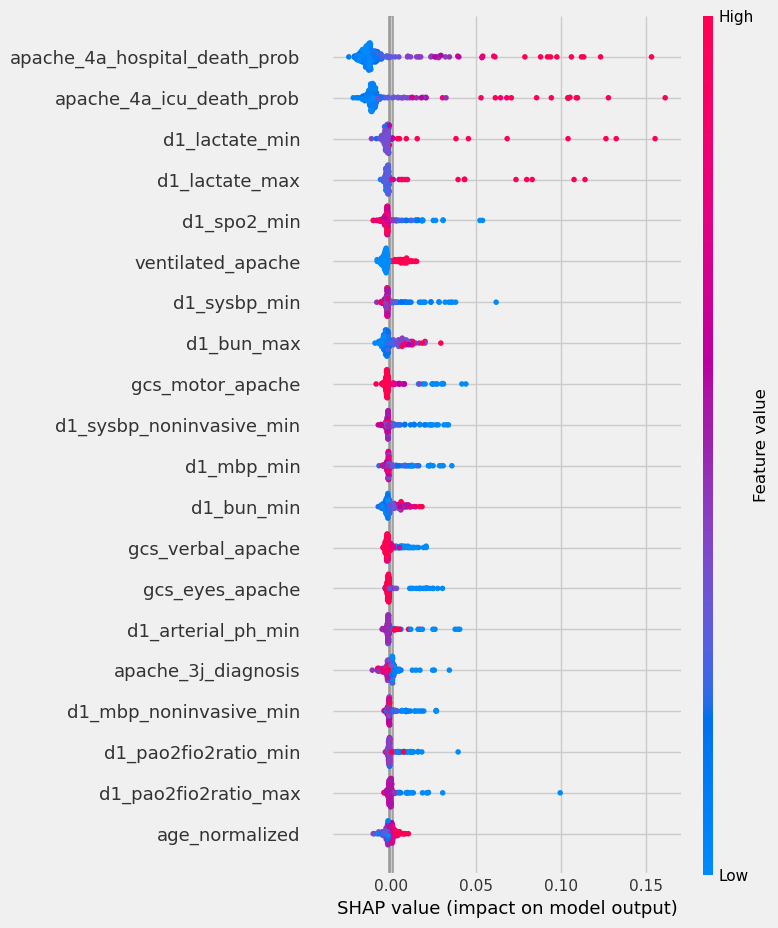

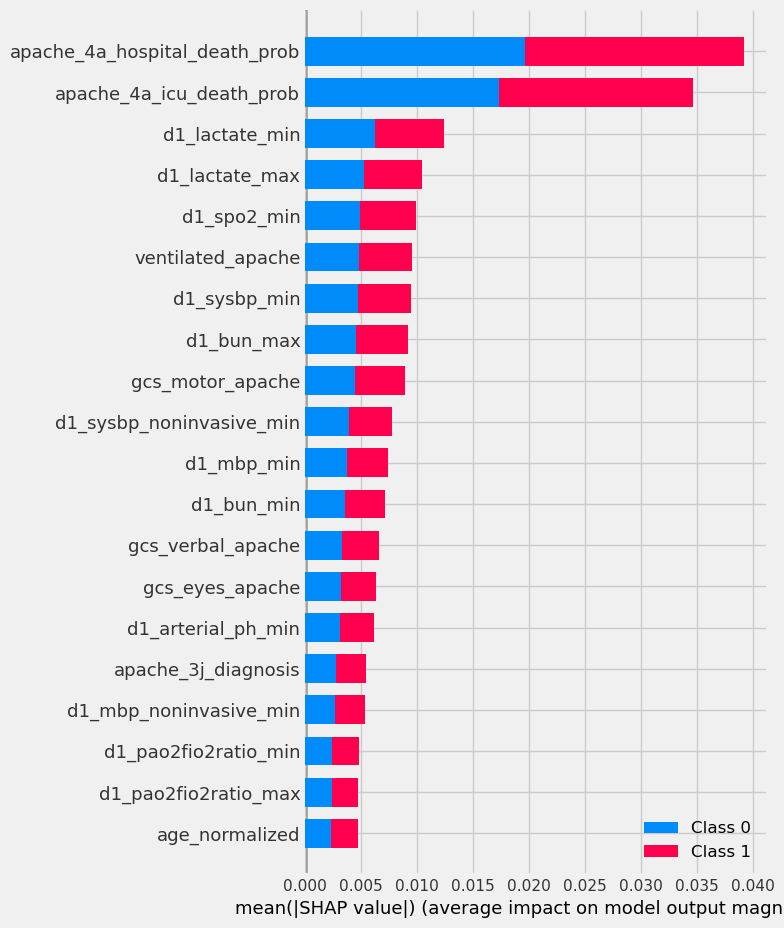

In [40]:
shap.summary_plot(shap_values_test[1], X_test)
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

# 9. Repeat the analysis from the previous section, but this time the test file must be filtered, so that it will only contain records whose classification was incorrect by the model.

Boolean Series key will be reindexed to match DataFrame index.


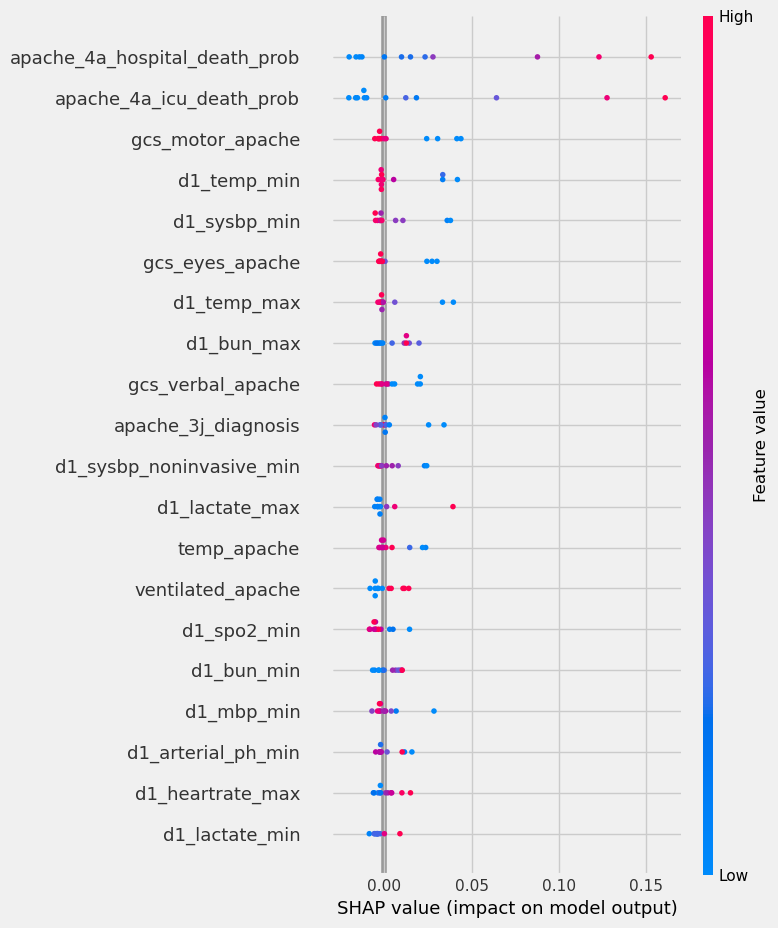

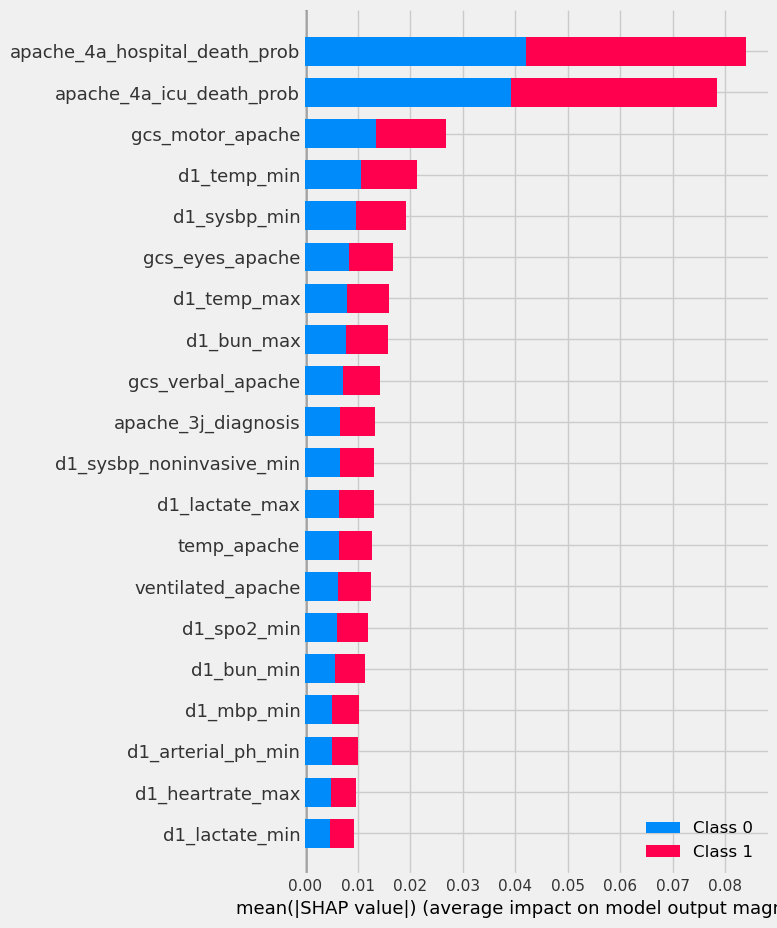

In [46]:
import shap

not_prediction_ = X_test[prediction_y != y_test]
filtered_length = len(not_prediction_)
sample_size = min(400, filtered_length)
sample_not_prediction = not_prediction_.sample(n=sample_size, random_state=42)

explainer_not_test = shap.TreeExplainer(random_forest)
values_not_test = explainer_not_test.shap_values(sample_not_prediction)

summary_plot_values = values_not_test[1]
summary_plot_data = sample_not_prediction

shap.summary_plot(summary_plot_values, summary_plot_data)
shap.summary_plot(values_not_test, not_prediction_, plot_type="bar")


# 10. Choose from the test file, 2 examples that were correctly classified and 2 examples that were incorrectly classified by your main model. Present the explanations given at the level of the individual records and describe them briefly.

In [ ]:

shap.force_plot(explainer_test.expected_value[0], shap_values_test[0][0], sample_not_prediction.iloc[0,:])

In [ ]:
shap.force_plot(explainer_test.expected_value[0], shap_values_test[0][1], sample_not_prediction.iloc[0,:])

In [ ]:
shap.force_plot(explainer_not_test.expected_value[0], values_not_test[0][1], sample_not_prediction.iloc[0,:])

In [ ]:
shap.force_plot(explainer_not_test.expected_value[0], values_not_test[0][0], sample_not_prediction.iloc[0,:])